# Introduction

In this IPython notebook, we'll show how to solve **Continuous Space-Action MDPs** (CSA-MDPs) defined as **Recurrent Models** in TensorFlow.

CSA-MDP is a mathematical model useful to represent discrete-time continuous dynamic systems. We won't bother formalizing the models, but we'll restrict ourselves to only define the necessary bits of information for you to understand the overall approach of **Planning through Backpropagation**, ok?

## Acknowledgments

This work is completely inspired by the work of Prof. Sanner and his PhD Students [Wu Ga](https://github.com/wuga214/) and Buser Say:

<blockquote>
**Scalable Planning with Tensorflow for Hybrid Nonlinear Domains**. arXiv preprint arXiv:1704.07511 (2017).
</blockquote>

Please [check it out](https://arxiv.org/abs/1704.07511) before diving into this notebook.

## Problem Formulation

As a running example, we'll consider the problem of navigation in a limited size 2D-grid with a (non-linear) deceleration zone in the center of the grid.

The Navigation 2D problem is defined as a CSA-MDP model where:

- the state space $\mathcal{S}= \{(x, y) \in \mathbb{R}^2 : \mathbf{l} \leq (x, y) \leq \mathbf{u} \}$ is the set of valid positions in a continuous grid space where $\mathbf{u}$ and $\mathbf{l}$ are its upper and lower bounds;
- the action space $\mathcal{A} = \{(\Delta_x, \Delta_y) \in [-1.0, 1.0] \times [-1.0, 1.0] \}$ represents continuous displacements in x and y directions;
- transition function $\mathcal{T}(\mathbf{s}, \mathbf{a})$ is such that:
$$
\begin{align}
\mathcal{T}(\mathbf{s}, \mathbf{a}) &= min(\mathbf{u}, max(\mathbf{l}, \mathbf{p})) \\
p &= \mathbf{s} + \lambda \mathbf{a} \\
\lambda &= \frac{2}{1 + e^{-\beta d}} -1 \\
d &= \parallel \mathbf{s} - \mathbf{z} \parallel
\end{align}
$$
where $\mathbf{z}$ is the center of the deceleration zone and $\beta$ is a decay factor;
- the reward function is given by $\mathcal{R}(\mathbf{s}, \mathbf{a}, \mathbf{s}') = - \parallel \mathbf{s} - \mathbf{g} \parallel $ where $\mathbf{g}$ is the goal position; 
- the initial state $\mathbf{s}^\star \in \mathcal{S}$ is a known fixed position.

<table>
<tr>
<td>
<img src="files/img/navigation-2D-nonlinear-grid.png" width="400px">
</td>
<td>
<img src="files/img/navigation-2D-nonlinear-deceleration.png" width="400px">
</td>
</tr>
</table>

The objective is to find a sequence of actions $\pi = \langle a_{1:H} \rangle$ that maximizes the cummulative reward gained over a given horizon $H$ from initial state $\mathbf{s}^\star$:
$$
\pi = \underset{a_{1:H}}{argmax} \sum_{i=1}^{H} \mathcal{R}(\mathbf{s}_t, \mathbf{a}_{t+1}, \mathbf{s}_{t+1})
$$

## Imports

First things first, let's import all the necessary libraries into our project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd

import abc
import time

%matplotlib inline

## Modeling MDPs in TensorFlow

All classes defining MDPs must inherit from abstract class ```TF_MDP```.

In [2]:
class TF_MDP(metaclass=abc.ABCMeta):
    
    @abc.abstractproperty
    def state_size(self):
        return
    
    @abc.abstractproperty
    def action_size(self):
        return

    @abc.abstractmethod
    def transition(self, state, action):
        return

    @abc.abstractmethod
    def reward(self, state, action):
        return

### Navigation in 2D grid with deceleration zone at the center

Let's extend the base class ```TF_MDP``` to define our Navigation 2D model in TensorFlow. Note that the transition and reward functions are a direct translation of the formulas laid out in the Introduction section.

In [3]:
class Navigation(TF_MDP):

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

        # grid constants
        self.__size = tf.constant(self.size, dtype=tf.float32)
        self.__center = tf.constant(self.center, dtype=tf.float32)
        self.__goal = tf.constant(self.goal, dtype=tf.float32)

        # numerical constants
        self.__0_00 = tf.constant(0.00, dtype=tf.float32)
        self.__1_00 = tf.constant(1.00, dtype=tf.float32)
        self.__2_00 = tf.constant(2.00, dtype=tf.float32)
        self.__decay = tf.constant(self.decay, dtype=tf.float32)

    @property
    def state_size(self):
        return self.ndim
    
    @property
    def action_size(self):
        return self.ndim
        
    def transition(self, state, action):
        # distance to center of grid
        d = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center), 1, keep_dims=True))

        # deceleration_factor
        deceleration = self.__2_00 / (self.__1_00 + tf.exp(-self.__decay * d)) - self.__1_00

        # next position
        next_state = state + deceleration * action
        next_state = tf.clip_by_value(next_state, self.__0_00, self.__size)

        return next_state

    def reward(self, state, action):
        # norm L-1 (manhattan distance)
        # return -tf.reduce_sum(tf.abs(state - self.__goal), 1, keep_dims=True)
        
        # norm L-2 (euclidean distance)
        return -tf.sqrt(tf.reduce_sum(tf.square(state - self.__goal), 1, keep_dims=True))


In [4]:
class Navigation4(TF_MDP):

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

        # grid constants
        self.__size = tf.constant(self.size, dtype=tf.float32)
        self.__center1 = tf.constant(self.center1, dtype=tf.float32)
        self.__center2 = tf.constant(self.center2, dtype=tf.float32)
        self.__center3 = tf.constant(self.center3, dtype=tf.float32)
        self.__center4 = tf.constant(self.center4, dtype=tf.float32)
        self.__goal = tf.constant(self.goal, dtype=tf.float32)

        # numerical constants
        self.__0_00 = tf.constant(0.00, dtype=tf.float32)
        self.__1_00 = tf.constant(1.00, dtype=tf.float32)
        self.__2_00 = tf.constant(2.00, dtype=tf.float32)
        self.__decay = tf.constant(self.decay, dtype=tf.float32)

    @property
    def state_size(self):
        return self.ndim
    
    @property
    def action_size(self):
        return self.ndim
        
    def transition(self, state, action):
        # distance to center of grid
        d1 = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center1), 1, keep_dims=True))
        d2 = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center2), 1, keep_dims=True))
        d3 = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center3), 1, keep_dims=True))
        d4 = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center4), 1, keep_dims=True))
        d5 = tf.minimum(d1,d2)
        d6 = tf.minimum(d3,d4)
        d = tf.minimum(d5,d6)

        # deceleration_factor
        deceleration = self.__2_00 / (self.__1_00 + tf.exp(-self.__decay * d)) - self.__1_00

        # next position
        next_state = state + deceleration  * action
        next_state = tf.clip_by_value(next_state, self.__0_00, self.__size)

        return next_state

    def reward(self, state, action):
        # norm L-1 (manhattan distance)
        # return -tf.reduce_sum(tf.abs(state - self.__goal), 1, keep_dims=True)
        
        # norm L-2 (euclidean distance)
        return -tf.sqrt(tf.reduce_sum(tf.square(state - self.__goal), 1, keep_dims=True))


## Encoding an MDP as a Recurrent Neural Net

Once the MDP transition and reward functions are in place in the computational graph, the next step towards representing the problem within a recurrent model is to encapsulate the MDP in a ```RNNCell``` as illustrated below.

<img src="files/img/mdp-cell.png" width="300px" >

In [5]:
class MDP_RNNCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, mdp):
        self.mdp = mdp

    @property
    def state_size(self):
        return mdp.state_size

    @property
    def output_size(self):
        return mdp.state_size + 1

    def __call__(self, inputs, state, scope=None):
        # x_t: cell inputs
        actions = inputs

        # h_t: cell state
        next_state =  self.mdp.transition(state, actions)

        # yhat_y: cell output
        reward = self.mdp.reward(next_state, actions)

        # outputs
        outputs = tf.concat([reward, next_state], 1)

        return outputs, next_state

To define the recurrent model over a given horizon, we need to perform the time unrolling with respect to the actions variables that inherently defines the horizon (i.e., ```max_time```).

In [6]:
class MDP_RNN(object):
    
    def __init__(self, mdp):
        self.cell = MDP_RNNCell(mdp)
    
    def unroll(self, actions, initial_state):
        # time unrolling
        outputs, final_state = tf.nn.dynamic_rnn(
            self.cell,
            actions,
            initial_state=initial_state,
            dtype=tf.float32)

        # separate reward and state series
        outputs = tf.unstack(outputs, axis=2)
        max_time = int(actions.shape[1])
        reward_series = tf.reshape(outputs[0], [-1, max_time, 1])
        state_series = tf.stack(outputs[1:], axis=2)

        return reward_series, state_series, final_state


## Defining the action optimizer

At this point we have defined the recurrent model representing the MDP unrolled for a given horizon. Before being able to finding the plan via backpropagation we need to define optimization operations that will go on top of our computation graph.

For this particular tutorial, we'll use the ```RMSPropOptimizer```. Note that the ```ActionOptimizer``` is parameterized by a ```loss``` function. We'll provide that in the next section.

In [7]:
class ActionOptimizer(object):
    
    def __init__(self, loss, learning_rate=0.001, limits=None, actions=None):
        self.loss = loss

        # optimization hyperparameters
        self.learning_rate = learning_rate

        # action constraints
        self.limits = None
        if limits is not None:
            self.limits = tf.assign(actions, tf.clip_by_value(actions, limits[0], limits[1]))

        # backprop via RMSProp
        self.train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

    def run(self, sess, epoch=100, show_progress=True):
        # initialize variables
        sess.run(tf.global_variables_initializer())
        
        losses = []
        for epoch_idx in range(epoch):
            # backprop and update weights
            sess.run(self.train_step)

            # maintain action constraints if any
            if self.limits is not None:
                sess.run(self.limits)

            # store and show loss information
            loss = sess.run(self.loss)
            losses.append(loss)
            if show_progress:
                print('Epoch {0:5}: loss = {1}\r'.format(epoch_idx, loss), end='')
        
        return losses


## Putting all together

We're almost there. The final step before running our action optimizer to find a plan is to define a ```loss``` (i.e., cost function). For this, we must first instantiate a concrete MDP model and unroll it for a predefined horizon.

<img src="files/img/mdp-recurrent.png" width="600px" />

### Instantiate the MDP model

In [8]:
params = {
    'ndim': 2,
    'size': (20.0, 20.0),
    'initial': (1.0, 1.0),
    'goal': (19.0, 19.0),
    'center1': (11.5, 9.5),
    'center2': (9.5, 11.5),
    'center3': (4.0, 4.0),
    'center4': (17.5, 17.5),
    'decay': 1.5,
    'limits': (-1.0, 1.0)
}

# MDP model
mdp = Navigation4(**params)

### Unroll the RNN for a given horizon

An indispensable step in building the unrolled recurrent model is to create the parameters to be optimized in our recurrent model!

In TensorFlow these are defined by the built-in tensors known as ```Variable```s. These are special tensors in the sense that they are the only ones that are persistent across executions in a ```Session```, which is absolutely necessary to perform batch optimization.

Another important point to understand (actually this is the crux of the approach) is that differently from the usual Recurrent Neural Nets (RNNs), we are not trying to optimize the inner parameters of the cell's state and output functions. Instead:

<blockquote>
"*we reverse the idea of training parameters of the network given fixed inputs to instead optimizing the inputs (i.e., actions) subject to fixed parameters (effectively the transition and reward parameterization assumed a priori known in planning)*".
</blockquote>

In [9]:
batch_size = 1000  # number of parallel planners
max_time = 23       # horizon H
state_size = 2     # grid 2D

# actions to optimize
actions = tf.Variable(
    tf.ones(shape=[batch_size, max_time, state_size]),
    name="actions")

# initial state
x_initial, y_initial = params['initial']
x_initial = tf.fill([batch_size], tf.constant(x_initial, tf.float32))
y_initial = tf.fill([batch_size], tf.constant(y_initial, tf.float32))
initial_state = tf.stack([x_initial, y_initial], axis=1)

# unrolled MDP model
mdp_rnn = MDP_RNN(mdp)
rewards, states, final_state = mdp_rnn.unroll(actions, initial_state)

### Define the optimization loss function

Finally, we can define the graph operations necessary to optimize our recurrent model. 

Note how we use the batch optimization for defining **paralell planners** so as to mitigate local minima problems of the overall cost function - *remember nothing guarantees that the MDP's transition and reward functions will imply in a well-behaved loss function to be optimized!*

In [10]:
# cumulative reward over horizon
total = -tf.reduce_sum(rewards, 1)

# Mean-Squared Error (MSE)
loss = tf.reduce_mean(tf.square(total))

# index of best solution among all planners
best_batch = tf.argmax(total,0)

### Optimize it!

Game is ON! Everything is in place for running the optimizer and finding a good plan for our Navigation 2D problem!

In [11]:
# action domain constraint [-1.0, 1.0]
limits = tf.constant(params['limits'], dtype=tf.float32)

# optimization hyper-parameters
epoch = 300
learning_rate = 0.05

# the start of the show!
optimizer = ActionOptimizer(loss, learning_rate, limits, actions)

start = time.time()

# optimize, babe!
with tf.Session() as sess:
    # run optimizer for a number of epochs
    losses = optimizer.run(sess, epoch)

    # get results per batch
    total_cost_per_batch = sess.run(total)

    # get results for best batch
    best_batch_idx         = sess.run(best_batch)
    best_batch_final_state = np.squeeze(sess.run(final_state)[best_batch_idx])
    best_batch_total_cost  = np.squeeze(sess.run(total)[best_batch_idx])
    best_batch_actions     = np.squeeze(sess.run(actions)[best_batch_idx])
    best_batch_states      = np.squeeze(sess.run(states)[best_batch_idx])
    best_batch_rewards     = np.squeeze(sess.run(rewards)[best_batch_idx])
    end_points = sess.run(final_state)

end = time.time()
print()
print("Done in {0:.8f} sec".format(end-start))

Epoch   299: loss = 75345.7890625
Done in 11.71447968 sec


## Visualizing results

Hopefully the optimization went smoothly. Now, let's visualize the results. Just run the following notebook cells to get some nice charts and information.

In [12]:
# reporting results
print("Final state =", best_batch_final_state)
print("Cost =", best_batch_total_cost)
print()

print("Action, State, Reward")
for a, s, r in zip(best_batch_actions, best_batch_states, best_batch_rewards):
    print("[{0:-10.6f}, {1:-10.6f}]".format(a[0], a[1]), end=', ')
    print("[{0:-10.6f}, {1:-10.6f}]".format(s[0], s[1]), end=', ')
    print("{0:-10.6f}".format(r))
    

Final state = [ 18.48172379  18.23199272]
Cost = 274.4915771484375

Action, State, Reward
[  0.636705,   1.000000], [  1.634516,   1.996561], -24.303846
[  0.100096,   1.000000], [  1.732715,   2.977616], -23.555805
[  1.000000,   1.000000], [  2.685886,   3.930787], -22.208815
[  1.000000,   1.000000], [  3.441945,   4.686846], -21.140469
[  1.000000,   1.000000], [  4.022787,   5.267687], -20.319777
[  1.000000,   0.991829], [  4.762986,   6.001839], -19.278091
[  1.000000,   0.966255], [  5.685662,   6.893379], -17.995607
[  1.000000,   0.954908], [  6.672577,   7.835792], -16.631443
[  1.000000,   0.947489], [  7.670648,   8.781451], -15.256899
[  1.000000,   0.214124], [  8.656084,   8.992457], -14.392620
[  1.000000,   0.947044], [  9.618986,   9.904368], -13.066519
[  1.000000,   1.000000], [ 10.452655,  10.738037], -11.887689
[  1.000000,   1.000000], [ 11.176140,  11.461522], -10.864687
[  1.000000,   1.000000], [ 12.026496,  12.311878],  -9.662335
[  1.000000,   1.000000], [ 

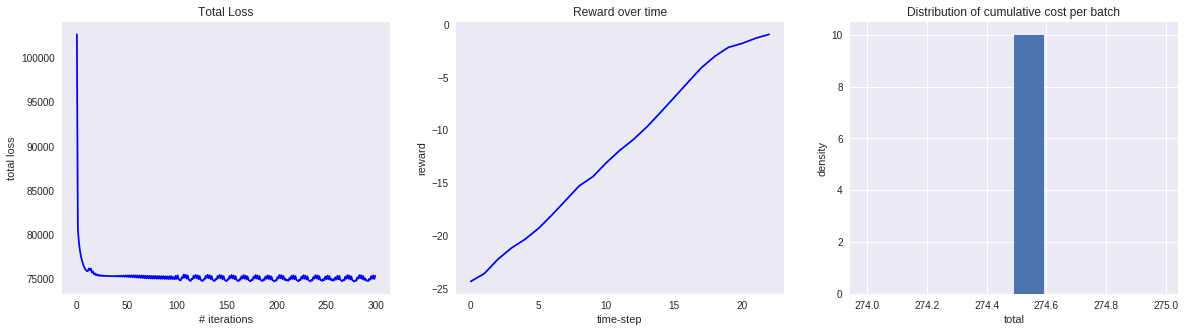

In [13]:
plt.figure(figsize=(20, 5))

# plotting losses
plt.subplot(131)
plt.plot(losses, 'b-')
plt.title('Total Loss')
plt.xlabel("# iterations")
plt.ylabel("total loss")
plt.grid()

# plotting rewards
plt.subplot(132)
plt.plot(best_batch_rewards, 'b-')
plt.title("Reward over time")
plt.xlabel("time-step")
plt.ylabel("reward")
plt.grid()

# histogram of cumulative cost per batch
plt.subplot(133)
plt.hist(total_cost_per_batch, normed=True, histtype='stepfilled')
plt.title('Distribution of cumulative cost per batch')
plt.xlabel('total')
plt.ylabel('density')

plt.show()

In [14]:
def plot_navigation(grid, states=None, actions=None, deceleration=True):

    # params
    xlim, ylim = grid['size']

    start, end = grid['initial'], grid['goal']

    # plot configuration
    plt.figure(figsize=(10, 10))
    plt.axis([0.0, xlim, 0.0, ylim])
    plt.axes().set_aspect('equal')
    plt.grid()
    plt.title("Navigation 2D", fontweight="bold", fontsize=16)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")

    # deceleration zone
    if deceleration:
        npoints = 1000
        for i in range(4):
            key_i = "center" + str(i+1)
            xcenter, ycenter = grid[key_i]
            X, Y = np.meshgrid(np.linspace(0.0, xlim, npoints), np.linspace(0.0, ylim, npoints))
            D = np.sqrt((X - xcenter) ** 2 + (Y - ycenter) ** 2)
            Lambda = 2 / (1 + np.exp(-grid['decay'] * D)) - 1.00
            ticks = np.arange(0.0, 1.01, 0.10)
            cp = plt.contourf(X, Y, Lambda, ticks, cmap=plt.cm.bone)
            cp = plt.contour(X, Y, Lambda, ticks, colors='black', linestyles='dashed')


    # actions
    if actions is not None:
        positions = np.concatenate([[start], states])
        plt.quiver(positions[:-1, 0], positions[:-1, 1], actions[:, 0], actions[:, 1],
                   angles='xy', scale_units='xy', scale=1, color='dodgerblue', width=0.005,
                   label='actions')
    # states
    if states is not None:
        plt.plot(positions[:, 0], positions[:, 1], 'o', color='darkblue', markersize=8, label='states')

    # start and end
    plt.plot([start[0]], [start[1]], marker='X', markersize=15, color='limegreen', label='initial')
    plt.plot([end[0]], [end[1]], marker='X', markersize=15, color='crimson', label='goal')
    plt.annotate('({0}, {1})'.format(start[0], start[1]), xy=(start[0]-0.5, start[1]-0.5))
    plt.annotate('({0}, {1})'.format(end[0], end[1]), xy=(end[0]-0.5, end[1]+0.5))

    plt.legend(loc='lower right')
    plt.show()


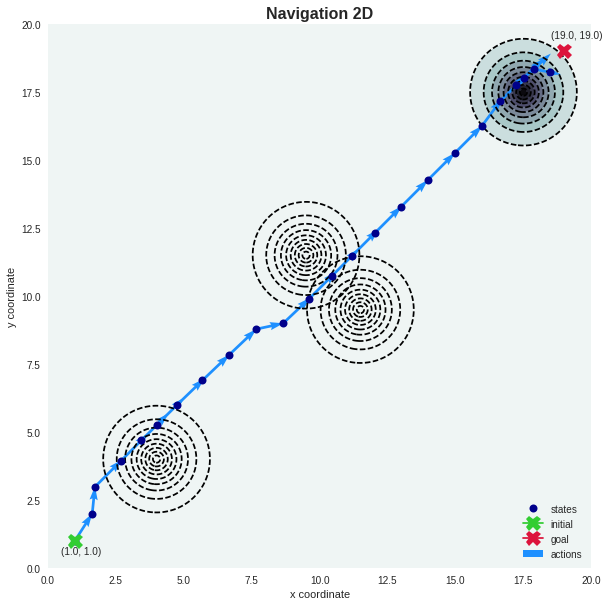

In [15]:
plot_navigation(params, best_batch_states, best_batch_actions)

We use a lot of planners (batch_size = 1000). We can see how many of them are close to the goal after the training.

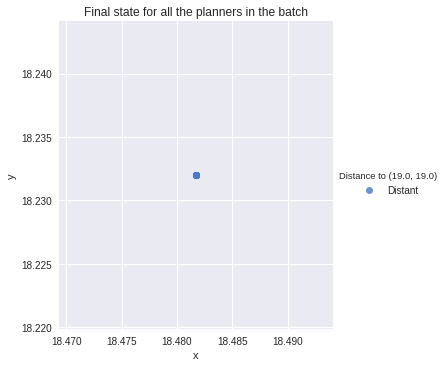

Planners close to the goal: 0
Planners not so close to the goal: 1000


In [16]:
distance_threshold = 0.1
x_inter = (params["goal"][0] - 0.1, params["goal"][0] + 0.5)
y_inter = (params["goal"][1] - 0.1, params["goal"][1] + 0.5)

x_goal = np.full(end_points.shape[0], params["goal"][0])
y_goal = np.full(end_points.shape[0], params["goal"][1])
all_targets = np.column_stack((x_goal, y_goal))

# calculating the distance for all planners in the batch
# using the euclidean distance
result = end_points - all_targets
result = result ** 2
result = np.sum(result, axis=1)
result = np.sqrt(result)
good = result <= distance_threshold


# using both pandas and numpy to plot the different points
distance = []
for value in good:
    if value:
        distance.append("Close")
    else:
        distance.append("Distant")
        
df = pd.DataFrame(data=end_points, columns=["x", "y"])
distance_collum = 'Distance to {}'.format(params["goal"])
df[distance_collum] = distance
my_palette = sns.color_palette("muted")
sns.lmplot(x="x", y="y", hue=distance_collum, data=df, fit_reg=False, palette=my_palette)
plt.title('Final state for all the planners in the batch')
plt.show()

print('Planners close to the goal: {}'.format(np.count_nonzero(good)))
print('Planners not so close to the goal: {}'.format(good.shape[0] - np.count_nonzero(good)))

## The End

This is the end! I hope you've got something interesting out of this tutorial!

Nevertheless, if you read the original paper and run this tutorial till the very end, but still have questions or suggestions, please feel free to drop a note on  ```thiago.pbueno``` @ ```gmail``` ```.com```.

Thanks for getting so far. Now go do something useful with your life, bro...

*Happy coding!!!*
